In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import spacescope    # api key to Spacescope
from datetime import datetime, timedelta
import dateutil.parser
from filterpy.kalman import predict, update
from filterpy.common import Q_discrete_white_noise
from prophet import Prophet
%config InlineBackend.figure_format = 'retina' 


### 0. Data extraction

In [2]:
url = "https://observable-api.starboard.ventures/network_storage_capacity/total_raw_bytes_power"
payload={}
response = requests.request("GET", url, data=payload)
df_rb = pd.DataFrame.from_dict(json.loads(response.text)['data'], orient='columns')

url = "https://observable-api.starboard.ventures/api/v1/observable/network-storage-capacity/new_baseline_power"
payload={}
response = requests.request("GET", url, data=payload)
df_bp = pd.DataFrame.from_dict(json.loads(response.text)['data'], orient='columns')

dataframe = df_rb.merge(df_bp)
dataframe.index = pd.to_datetime(dataframe.stat_date, errors='coerce')
dataframe.total_raw_bytes_power = pd.to_numeric(dataframe.total_raw_bytes_power, errors='coerce')
dataframe.new_baseline_power = pd.to_numeric(dataframe.new_baseline_power, errors='coerce')

<AxesSubplot:xlabel='stat_date'>

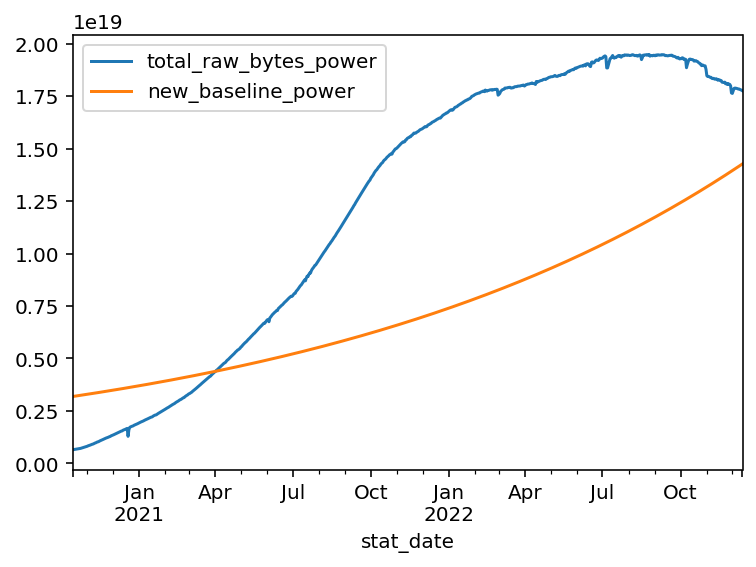

In [3]:
dataframe[['total_raw_bytes_power', 'new_baseline_power']].plot()

Based on this graph, it seems that there will be a second crossover coming soon. The question is, when?

### 1. Forward prediction of the raw byte power with a seasonal Kalman filter

Here I carry out a seasonal state space model, based on the hypothesis that the raw byte power will mean revert about the plateau value. The recipe here follows the formulation of Davis and Keck. The state vector is

$$ {\bf X}_t = \begin{bmatrix} m_t & s_t & s_{t-1} & \cdots & s_{t-d+2}  \end{bmatrix}^T $$

which includes the trend and the $d-1$ most recent seasonality values. To have seasonal memory over $N$ lags the matrices must have a rank of $N+1$. 

The observation model

$$ H = \begin{bmatrix}  1 & 1 & \cdots & 0 \end{bmatrix} $$

Observation noise 

$$ R = \begin{bmatrix} \sigma_w \end{bmatrix} $$

Transition state matrix

$$ F = \begin{bmatrix} 1 & 0 & 0 & \cdots & 0 & 0 \\ 0 & -1 & -1 & \cdots & -1 & -1 \\ 0 & 1 & 0 & \cdots & 0 & 0 \\ 0 & 0 & 1 & \cdots & 0 & 0  \\ \vdots & \vdots & \vdots  & \ddots & \vdots & \vdots \\ 0 & 0 & 0 & \cdots & 1 & 0 \end{bmatrix} $$

Transition covariance matrix

$$ Q = \begin{bmatrix}\sigma_v^1 & \sigma_v^2 & 0 & \cdots & 0 \end{bmatrix} $$

In [4]:
class Kalman(object):
    
    '''
    A Numpy implementation of the Kalman filter. Notation follows the Wikipedia page.
    '''
    
    def __init__(self, F=None, H=None, Q=None, R=None, P=None, x0=None):
        
        self.n = F.shape[1]
        self.m = H.shape[1]
        
        self.F = F # State transition model
        self.H = H # Observation model
        self.Q = Q # Covariance of process noise 
        self.R = R # Covariance of observation noise

        self.x = np.zeros((self.n,1)) if x0 is None else x0
        self.P = np.eye(self.n) if P is None else P
    
    def predict(self):
        # A priori state estimate 
        self.x = self.F.dot(self.x)  
        
        # A priori covariance estimate
        self.P = self.F.dot(self.P).dot(self.F.T) + self.Q

        return(self.x)
        
    def update(self, z):  
        # z is an observation of true state where z = Hx + v, it's updated out of loop
        
        # Measurement prefit residual
        y = z - self.H.dot(self.x)
        
        # Prefit residual covariance
        S = self.H.dot(self.P).dot(self.H.T) + self.R
        
        # Optimal Kalman gain
        K = self.P.dot(self.H.T).dot(np.linalg.inv(S))
        
        # A posteriori state estimate
        self.x = self.x + K.dot(y)
        
        # A posteriori covariance estimate
        I = np.eye(self.n)
        self.P = (I - K.dot(self.H)).dot(self.P)
        

In [5]:
def generate_observation_model(n_period=5):
    '''
    Generates the observation model for the seasonal Kalman filter 
    '''
    assert n_period > 2, "n_period must be more than 2"
    H = np.zeros((1,n_period))
    H[:,0] = 1
    H[:,1] = 1
    return(H)

def generate_state_transition_matrix(n_period=5):
    '''
    Generates the state transition matrix for a classical decomposition with trend, seasonal and noise component. 

    Parameters
    ----------
    n_period: int
        Periodicity for the seasonal component, in lags

    Returns
    -------
    F: numpy array
        The state transition matrix for the so-called seasonal Kalman filter. 
    '''
    F = np.zeros((n_period+1, n_period+1))
    F[0,0] = 1
    F[1, 1:-1] = [-1.0] * (n_period-1)
    F[2:, 1:-1] = np.eye(n_period - 1)
    return(F)

def generate_transition_covariance_matrix(n_period=5, noise_arr=[0.01, 1e-3]):
    P = np.diag(noise_arr + [0]*(n_period-1))**2
    return(P)

def generate_observation_noise(noise):
    R = noise
    return R**2

Predicted crossover 2023-04-07 00:00:00+00:00


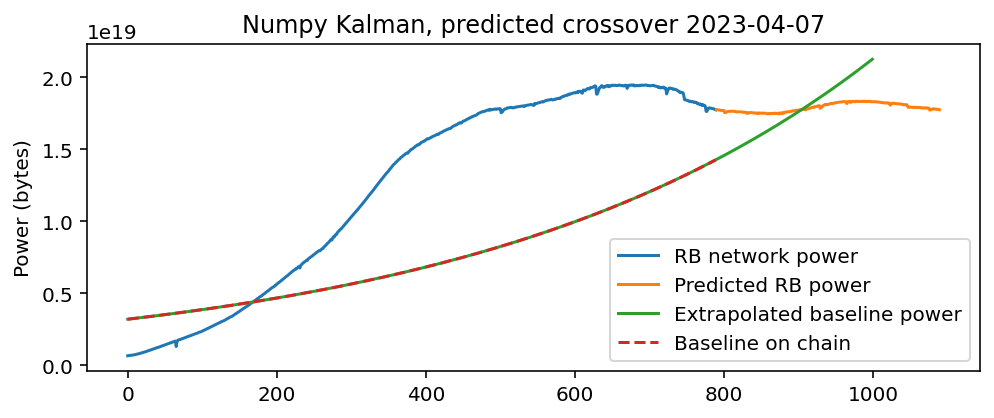

In [7]:
N = 300
F = generate_state_transition_matrix(N)
H = generate_observation_model(N+1)
Q = generate_transition_covariance_matrix(N)
R = generate_observation_noise(1e-3)

dynamic_baseline = lambda x: dataframe.new_baseline_power.iloc[0] * np.exp(np.log(2)/31536000*x*86400)

measurements = dataframe.total_raw_bytes_power.values
kf = Kalman(F, H, Q, R)
predictions = []
for z in measurements:
    predictions.append(np.dot(H, kf.predict())[0][0])
    kf.update(z)

forward_predictions = []
for i in range(300):
    forward_predictions.append(np.dot(H, kf.predict())[0][0])    

interval_delta = len(measurements) + np.argmin(np.abs(np.array(forward_predictions) -\
                 dynamic_baseline(np.arange(len(measurements), len(measurements)+len(forward_predictions)))))
crossover_date = dateutil.parser.parse(str(dataframe.stat_date.iloc[0])) + timedelta(days=int(interval_delta))                 
print("Predicted crossover %s" % crossover_date)                 

plt.figure(figsize=(8,3))
plt.plot(measurements, label='RB network power')
plt.plot(np.arange(len(forward_predictions))+len(measurements), forward_predictions, label='Predicted RB power')
dynamic_baseline = lambda x: dataframe.new_baseline_power.iloc[0] * np.exp(np.log(2)/31536000*x*86400)
plt.plot(dynamic_baseline(np.arange(1000)), label='Extrapolated baseline power')
plt.plot(dataframe.new_baseline_power.values, '--', label='Baseline on chain')
plt.ylabel('Power (bytes)')
plt.title('Numpy Kalman, predicted crossover %s' % str(crossover_date.date()))
plt.legend(loc='best')

Predicted crossover 2023-04-22 00:00:00+00:00


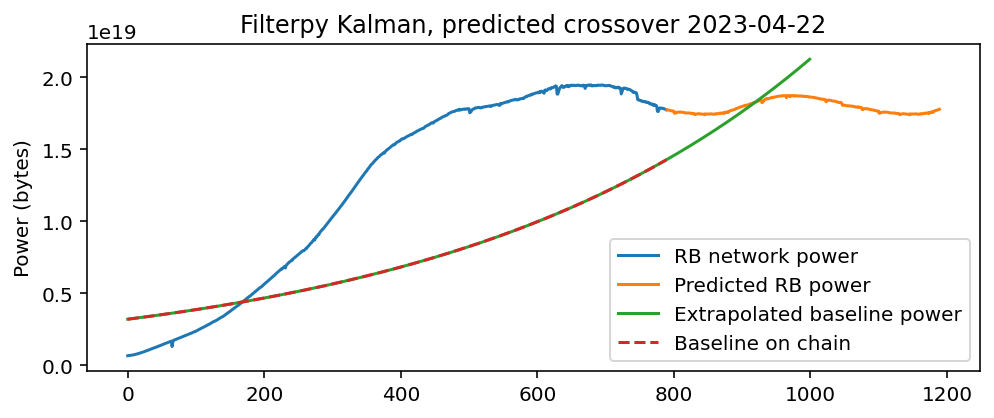

In [8]:
measurements = dataframe.total_raw_bytes_power.values

x0 = np.append(np.mean(measurements), measurements[0:300]-np.mean(measurements[0:300]))
P0 = 1*np.eye(N+1)

forward_predictions = []
for i in range(len(measurements)):
    if i==0:
        x = x0
        P = P0
    x, P = predict(x, P, F, Q)
    zz = np.dot(H,x)    
    x, P = update(x, P, measurements[i], R, H)
    
# Forward prediction    
for j in range(400):
    x = np.dot(F, x)
    z = np.dot(H, x)
    forward_predictions.append(z[0])    

interval_delta = len(measurements) + np.argmin(np.abs(np.array(forward_predictions) -\
                 dynamic_baseline(np.arange(len(measurements), len(measurements)+len(forward_predictions)))))
crossover_date = dateutil.parser.parse(str(dataframe.stat_date.iloc[0])) + timedelta(days=int(interval_delta))                 
print("Predicted crossover %s" % crossover_date)                 

plt.figure(figsize=(8,3))
plt.plot(measurements, label='RB network power')
plt.plot(np.arange(len(forward_predictions))+len(measurements), forward_predictions, label='Predicted RB power')
dynamic_baseline = lambda x: dataframe.new_baseline_power.iloc[0] * np.exp(np.log(2)/31536000*x*86400)
plt.plot(dynamic_baseline(np.arange(1000)), label='Extrapolated baseline power')
plt.plot(dataframe.new_baseline_power.values, '--', label='Baseline on chain')
plt.ylabel('Power (bytes)')
plt.title('Filterpy Kalman, predicted crossover %s' % str(crossover_date.date()))
plt.legend(loc='best')


### 2. Local linear trend

Another simple option to try is a local linear trend. 

It's also possible to use other models such as an ARMA model. The Kalman matrices for ARMA models can be found in many texts e.g. Brockwell and Davis. The Kalman matrices depend explicitly on the coefficients of the ARMA model, meaning that these have to be fitted first on historical data. 

In [9]:
F = np.array([[1,1],[0,1]])
H = np.array([1,0]).reshape(1,2)
Q = Q_discrete_white_noise(dim=2, dt=1, var=1e-3)
R = np.array([1e-3]).reshape(1,1)


In [10]:
measurements = dataframe.total_raw_bytes_power.values
kf = Kalman(F, H, Q, R)
predictions = []
for z in measurements:
    predictions.append(np.dot(H, kf.predict())[0][0])
    kf.update(z)

forward_predictions = []
for i in range(300):
    forward_predictions.append(np.dot(H, kf.predict())[0][0])    


Predicted crossover 2023-02-19 00:00:00+00:00


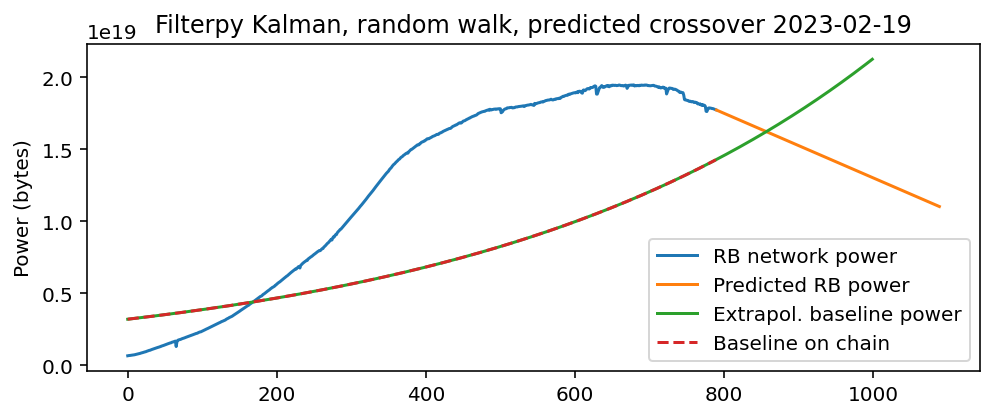

In [11]:
interval_delta = len(measurements) + np.argmin(np.abs(np.array(forward_predictions) -\
                 dynamic_baseline(np.arange(len(measurements), len(measurements)+len(forward_predictions)))))
crossover_date = dateutil.parser.parse(str(dataframe.stat_date.iloc[0])) + timedelta(days=int(interval_delta))                 
print("Predicted crossover %s" % crossover_date)                 


plt.figure(figsize=(8,3))
plt.plot(measurements, label='RB network power')
plt.plot(np.arange(len(forward_predictions))+len(measurements), forward_predictions, label='Predicted RB power')
dynamic_baseline = lambda x: dataframe.new_baseline_power.iloc[0] * np.exp(np.log(2)/31536000*x*86400)
plt.plot(dynamic_baseline(np.arange(1000)), label='Extrapol. baseline power')
plt.plot(dataframe.new_baseline_power.values, '--', label='Baseline on chain')
plt.ylabel('Power (bytes)')
plt.title('Filterpy Kalman, random walk, predicted crossover %s' % str(crossover_date.date()))

plt.legend(loc='best')

### 3. Prophet

A last option is a catch-all, magical black box. 

In [13]:
dc = df_rb.copy()

dc.columns = ['ds', 'y']
dc.ds = dc.ds.astype(str).str[:10]
dc['y'] = pd.to_numeric(dc['y'], errors='coerce')

m = Prophet()
m.fit(dc)

future = m.make_future_dataframe(periods=300)
fcst = m.predict(future)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -19.2118
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3746.61     0.0109112       3228.47           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3952.46    0.00815517       3813.58           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4073.21    0.00477943       3237.44           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        4081.7   0.000697855        1797.9      0.7644      0.7644      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4107.71   0.000626994       1880.67           1           1      568   
    Iter      log prob        ||dx||      ||grad||       alpha  

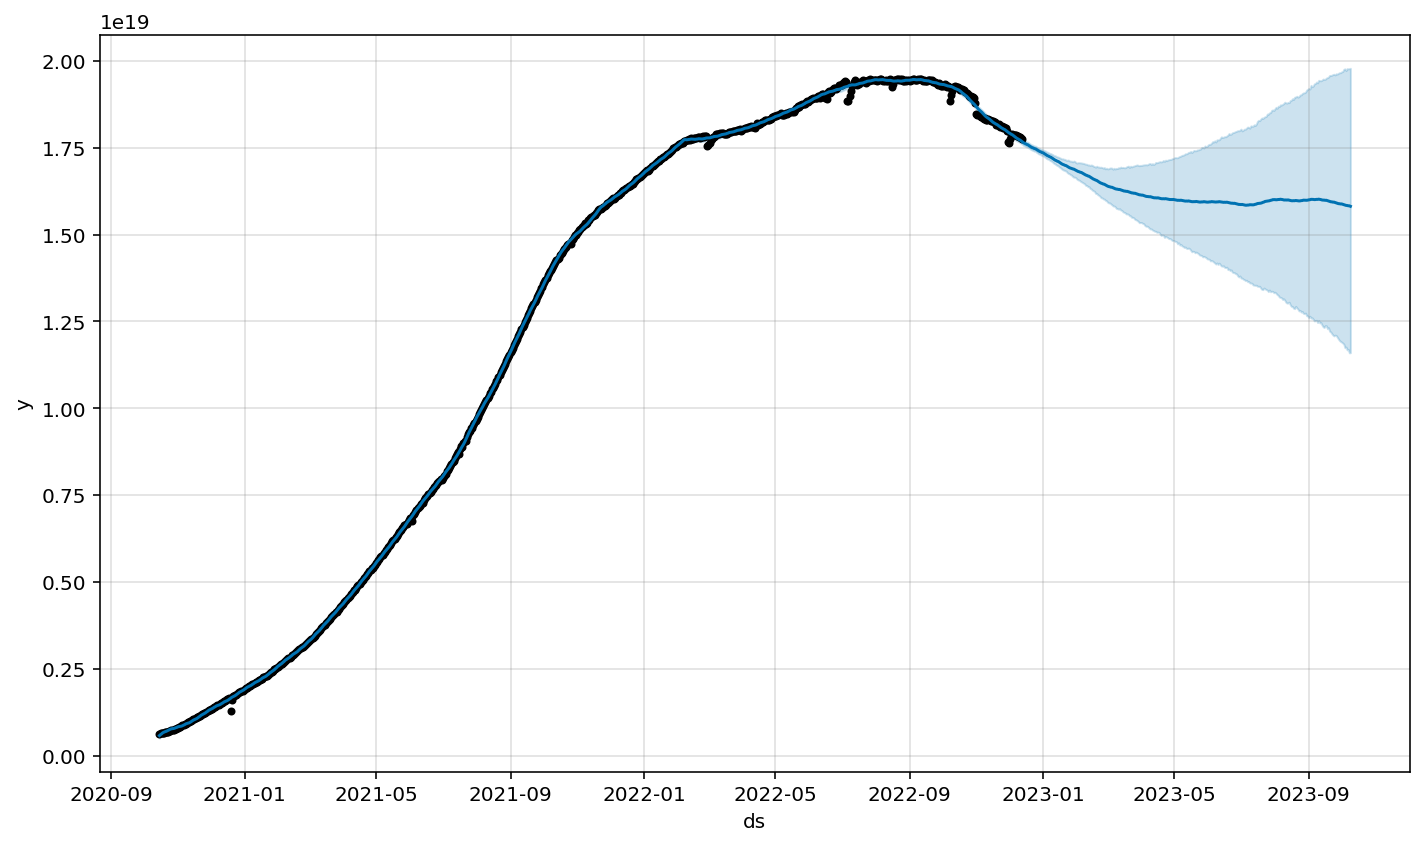

In [15]:
fig = m.plot(fcst)

Predicted crossover 2023-02-26 00:00:00+00:00


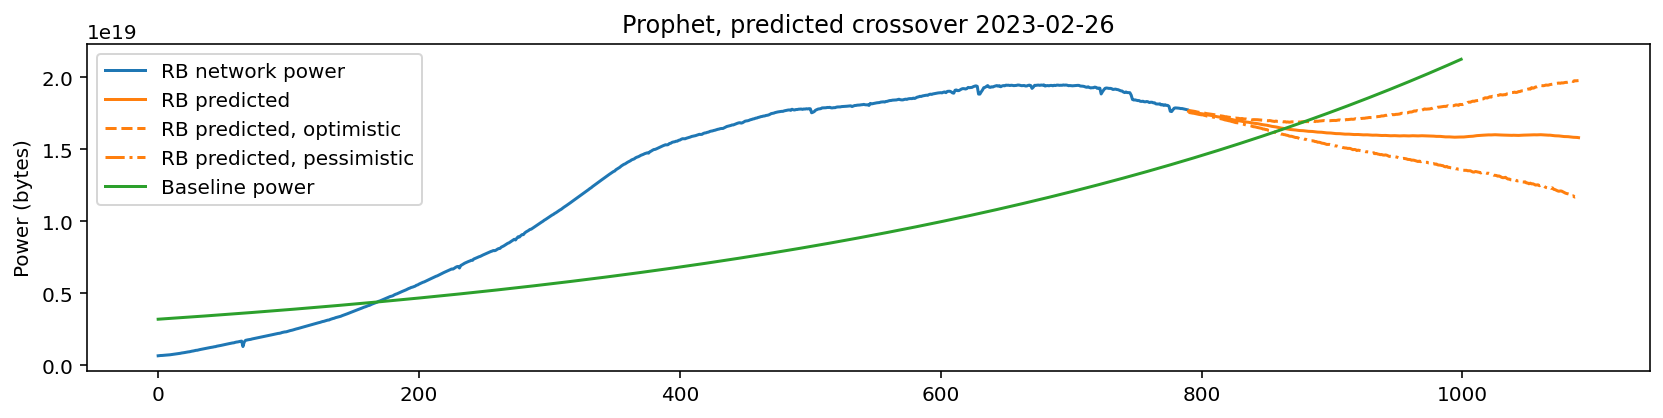

In [26]:
plt.figure(figsize=(14,3))

interval_delta = len(dc) + np.argmin(np.abs(fcst['yhat'][-300:].values - dynamic_baseline(np.arange(len(fcst)-300, len(fcst)))))
crossover_date = dateutil.parser.parse(str(dataframe.stat_date.iloc[0])) + timedelta(days=int(interval_delta))                 
print("Predicted crossover %s" % crossover_date)         
plt.plot(measurements, label='RB network power')
plt.plot(np.arange(len(dc), len(fcst)), fcst['yhat'].iloc[-300:], label='RB predicted')

plt.plot(np.arange(len(dc), len(fcst)), fcst['yhat_upper'].iloc[-300:], '--', label='RB predicted, optimistic', c='C1')
plt.plot(np.arange(len(dc), len(fcst)), fcst['yhat_lower'].iloc[-300:], '-.', label='RB predicted, pessimistic', c='C1')

plt.plot(dynamic_baseline(np.arange(1000)), label='Baseline power')
# plt.plot(dataframe.new_baseline_power.values, '--', label='Baseline on chain')
plt.ylabel('Power (bytes)')
plt.title('Prophet, predicted crossover %s' % str(crossover_date.date()))
plt.legend(loc='best')

In [28]:
col_list = ['yhat_lower', 'yhat', 'yhat_upper']
for col in col_list:
    interval_delta = len(dc) + np.argmin(np.abs(fcst[col][-300:].values - dynamic_baseline(np.arange(len(fcst)-300, len(fcst)))))
    crossover_date = dateutil.parser.parse(str(dataframe.stat_date.iloc[0])) + timedelta(days=int(interval_delta))                 
    print("Crossover (%s) \t %s" % (col, crossover_date))         


Crossover (yhat_lower) 	 2023-02-18 00:00:00+00:00
Crossover (yhat) 	 2023-02-26 00:00:00+00:00
Crossover (yhat_upper) 	 2023-03-13 00:00:00+00:00
